# TASK 1

In [ ]:
import nltk
import spacy
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models import Word2Vec, FastText
from gensim.models.keyedvectors import KeyedVectors

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

data = """Aragorn sped on up the hill. Every now and again he bent to the 
ground. Hobbits go light, and their footprints are not easy even for
a Ranger to read, but not far from the top a spring crossed the path,
and in the wet earth he saw what he was seeking.

‘I read the signs aright,’ he said to himself. ‘Frodo ran to the
hill-top. I wonder what he saw there? But he returned by the same
way, and went down the hill again.’

Aragorn hesitated. He desired to go to the high seat himself,
hoping to see there something that would guide him in his perplexities; but time was pressing. 
Suddenly he leaped forward, and
ran to the summit, across the great flag-stones, and up the steps.
Then sitting in the high seat he looked out. But the sun seemed
darkened, and the world dim and remote. He turned from the North
back again to North, and saw nothing save the distant hills, unless
it were that far away he could see again a great bird like an eagle
high in the air, descending slowly in wide circles down towards the
earth.

Even as he gazed his quick ears caught sounds in the woodlands
below, on the west side of the River. He stiffened. There were cries,
and among them, to his horror, he could distinguish the harsh voices
of Orcs. Then suddenly with a deep-throated call a great horn blew,
and the blasts of it smote the hills and echoed in the hollows, rising
in a mighty shout above the roaring of the falls."""

sentences = sent_tokenize(data)

#preprocessing text function
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)  #tokenization
    tokens = [word for word in tokens if word.isalpha()]  #punctuation removal
    tokens = [word for word in tokens if word not in stopwords.words('english')]  #stopwords removal
    tokens = [nlp(word)[0].lemma_ for word in tokens]  #lemmatization
    return tokens

processed_text = [preprocess_text(sentence) for sentence in sentences]

print(processed_text)

In [ ]:
from gensim.models import Word2Vec

#CBOW model
cbow_model = Word2Vec(sentences=processed_text, vector_size=100, window=5, min_count=1, workers=4, sg=0)

#skip-gram
skipgram_model = Word2Vec(sentences=processed_text, vector_size=100, window=5, min_count=1, workers=4, sg=1)

cbow_model.save("cbow_model.model")
skipgram_model.save("skipgram_model.model")


In [ ]:
from gensim.models import FastText

#fastText model
fasttext_model = FastText(sentences=processed_text, vector_size=100, window=5, min_count=1, workers=4)

fasttext_model.save("fasttext_model.model")


In [ ]:
import gensim.downloader as api

#gloVe vectors
glove_model = api.load("glove-wiki-gigaword-100")

print(glove_model["aragorn"])


In [ ]:
from scipy.spatial.distance import cosine

#cosine similarity between "aragorn" and "frodo"
def cosine_similarity(model, word1, word2):
    return 1 - cosine(model.wv[word1], model.wv[word2])


print("CBOW:", cosine_similarity(cbow_model, "aragorn", "frodo"))
print("Skip-gram:", cosine_similarity(skipgram_model, "aragorn", "frodo"))
print("FastText:", cosine_similarity(fasttext_model, "aragorn", "frodo"))
print("GloVe:", 1 - cosine(glove_model["aragorn"], glove_model["frodo"]))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


def get_embeddings(model, words):
    embeddings = np.array([model.wv[word] for word in words if word in model.wv])
    if len(embeddings) == 0:
        raise ValueError("No valid words found in the model vocabulary.")
    return embeddings


def plot_tsne(model, words, title="t-SNE Visualization"):
    embeddings = get_embeddings(model, words)
    perplexity = min(30, len(embeddings) - 1)
    
    tsne = TSNE(n_components=2, random_state=111, perplexity=perplexity, n_iter=3000)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
    
    for i, word in enumerate(words):
        if word in model.wv:
            plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9, alpha=0.7)

    
    plt.title(title)
    plt.show()


def plot_pca(model, words, title="PCA Visualization"):
    embeddings = get_embeddings(model, words)
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
    
    for i, word in enumerate(words):
        if word in model.wv:
            plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9, alpha=0.7)
    
    plt.title(title)
    plt.show()

words_to_visualize = ["aragorn", "frodo", "hill", "river", "eagle"]

plot_tsne(cbow_model, words_to_visualize, title="t-SNE visualization of Word2Vec embeddings")
plot_pca(fasttext_model, words_to_visualize, title="PCA visualization of FastText embeddings")


# TASK 2

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split

class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, target_model):
        super(GradientLogger, self).__init__()
        self.target_model = target_model
        self.gradient_values = []

    def on_train_batch_end(self, batch, logs=None):
        with tf.GradientTape() as tape:
            y_pred = self.target_model(X_train[:100], training=True)
            y_true = tf.reshape(y_train[:100], (-1, 1))
            loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
            
        grads = tape.gradient(loss, self.target_model.trainable_variables)
        avg_grads = [np.mean(np.abs(tf.convert_to_tensor(g).numpy())) for g in grads if g is not None]
        self.gradient_values.append(np.mean(avg_grads))




max_words = 10000
max_len = 200

#IMDb Dataset preparation
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)


X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=111, stratify=y_train
)


# RNN

In [25]:
#RNN model
model_RNN = Sequential([
    Embedding(max_words, 128),
    SimpleRNN(50, activation="tanh", return_sequences=True),
    SimpleRNN(50, activation="tanh", return_sequences=True),
    SimpleRNN(50, activation="tanh"),
    Dense(1, activation='sigmoid')
])

model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


grad_logger_RNN = GradientLogger(model_RNN)

In [26]:
history_RNN = model_RNN.fit(X_train, y_train, epochs=15, batch_size=300, validation_data=(X_val, y_val), callbacks=[grad_logger_RNN])

Epoch 1/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5105 - loss: 0.7090 - val_accuracy: 0.5622 - val_loss: 0.6745
Epoch 2/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6330 - loss: 0.6050 - val_accuracy: 0.5944 - val_loss: 0.6704
Epoch 3/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7228 - loss: 0.4471 - val_accuracy: 0.5600 - val_loss: 0.7821
Epoch 4/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7574 - loss: 0.3871 - val_accuracy: 0.5534 - val_loss: 0.8658
Epoch 5/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7858 - loss: 0.3413 - val_accuracy: 0.5082 - val_loss: 0.9943
Epoch 6/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7442 - loss: 0.3955 - val_accuracy: 0.5350 - val_loss: 1.1381
Epoch 7/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8288 - loss: 0.2892 - val_accuracy: 0.5472 - val_loss: 1.1206
Epoch 8/15
67/67 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8751 - loss: 0.2202 - val_accuracy: 0.5288 - v

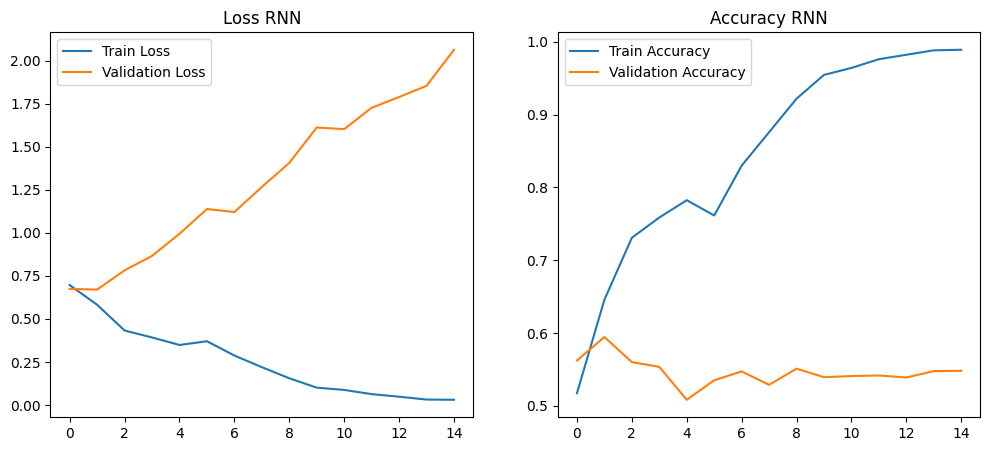

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_RNN.history['loss'], label='Train Loss')
plt.plot(history_RNN.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss RNN')

plt.subplot(1, 2, 2)
plt.plot(history_RNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_RNN.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy RNN')
plt.show()

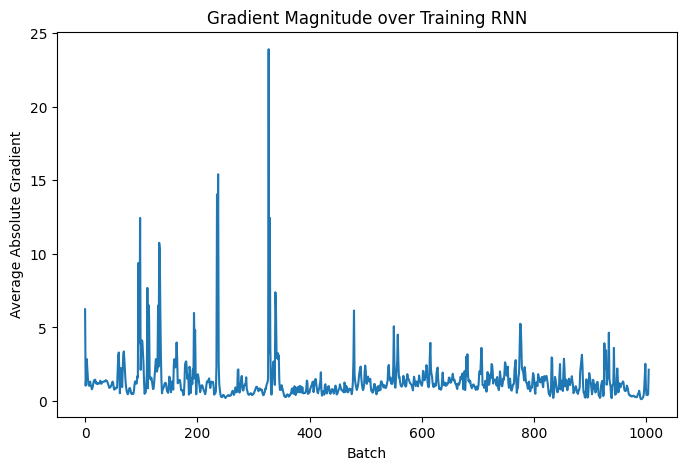

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(grad_logger_RNN.gradient_values)
plt.title("Gradient Magnitude over Training RNN")
plt.xlabel("Batch")
plt.ylabel("Average Absolute Gradient")
plt.show()

# TASK 3

# LSTM

In [8]:
from tensorflow.keras.layers import LSTM

model_LSTM = Sequential([
    Embedding(max_words, 128),
    LSTM(100, activation="tanh", return_sequences=True),
    LSTM(100, activation="tanh"),
    Dense(1, activation='sigmoid')
])
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


grad_logger_LSTM = GradientLogger(model_LSTM)


In [9]:
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, batch_size=300, validation_data=(X_val, y_val), callbacks=[grad_logger_LSTM])

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.5128 - loss: 0.6967 - val_accuracy: 0.5494 - val_loss: 0.6889
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.5788 - loss: 0.6752 - val_accuracy: 0.5534 - val_loss: 0.6737
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.6689 - loss: 0.5753 - val_accuracy: 0.7636 - val_loss: 0.5198
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8176 - loss: 0.4577 - val_accuracy: 0.5498 - val_loss: 0.8319
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.6044 - loss: 0.6420 - val_accuracy: 0.6338 - val_loss: 0.5932
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.7953 - loss: 0.4494 - val_accuracy: 0.7972 - val_loss: 0.4931
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.8734 - loss: 0.3287 - val_accuracy: 0.8384 - val_loss: 0.3930
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9071 - loss: 0.2518 - val_accuracy: 0.

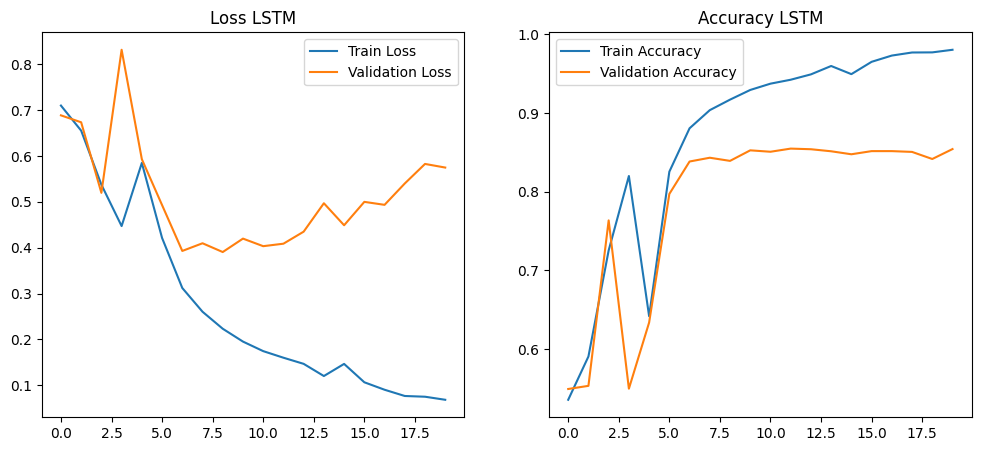

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss LSTM')



plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history['accuracy'], label='Train Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy LSTM')
plt.show()

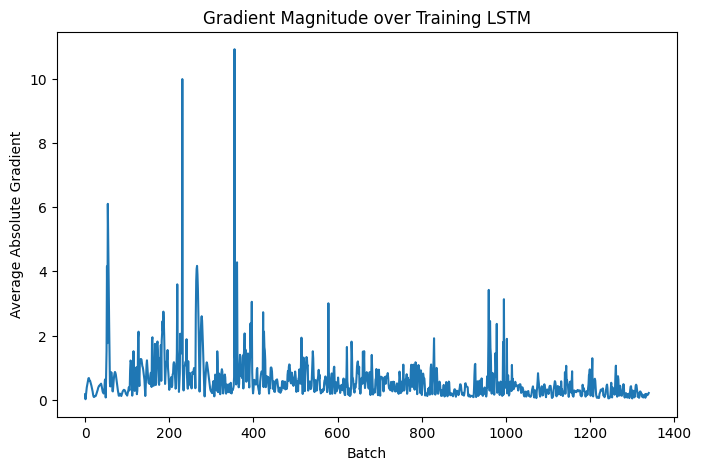

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(grad_logger_LSTM.gradient_values)
plt.title("Gradient Magnitude over Training LSTM")
plt.xlabel("Batch")
plt.ylabel("Average Absolute Gradient")
plt.show()

# GRU

In [12]:
from tensorflow.keras.layers import GRU

model_GRU = Sequential([
    Embedding(max_words, 128),
    GRU(100, activation="tanh", return_sequences=True),
    GRU(100, activation="tanh"),
    Dense(1, activation='sigmoid')
])

model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



grad_logger_GRU = GradientLogger(model_GRU)



In [13]:
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, batch_size=300, validation_data=(X_val, y_val), callbacks=[grad_logger_GRU])

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5243 - loss: 0.6895 - val_accuracy: 0.5696 - val_loss: 0.6620
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.6200 - loss: 0.6203 - val_accuracy: 0.5596 - val_loss: 0.6788
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.5935 - loss: 0.6445 - val_accuracy: 0.6034 - val_loss: 0.6304
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.6689 - loss: 0.5529 - val_accuracy: 0.6006 - val_loss: 0.6417
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.7108 - loss: 0.4950 - val_accuracy: 0.8184 - val_loss: 0.4450
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8697 - loss: 0.3417 - val_accuracy: 0.8380 - val_loss: 0.4084
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8930 - loss: 0.2738 - val_accuracy: 0.8478 - val_loss: 0.3862
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9216 - loss: 0.2158 - val_accuracy: 0.8576 - v

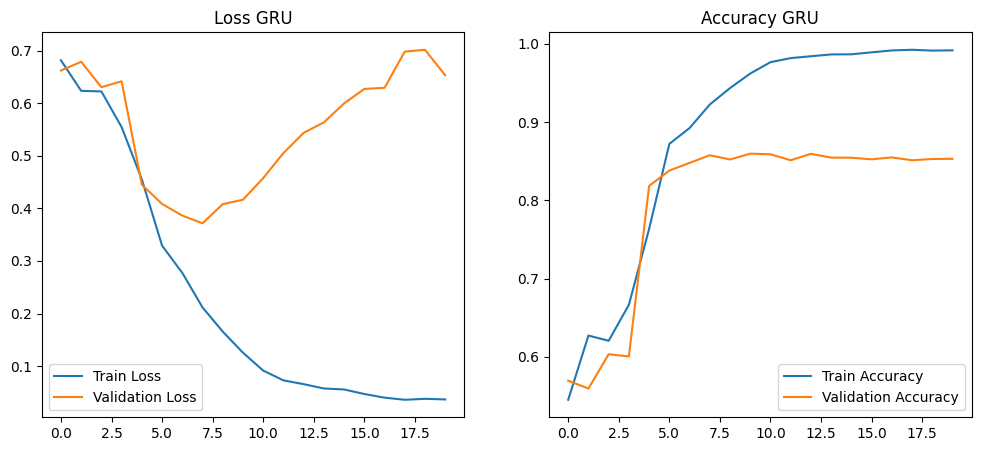

In [14]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['loss'], label='Train Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss GRU')

plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['accuracy'], label='Train Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy GRU')
plt.show()

Text(0.5, 1.0, 'Loss LSTM')

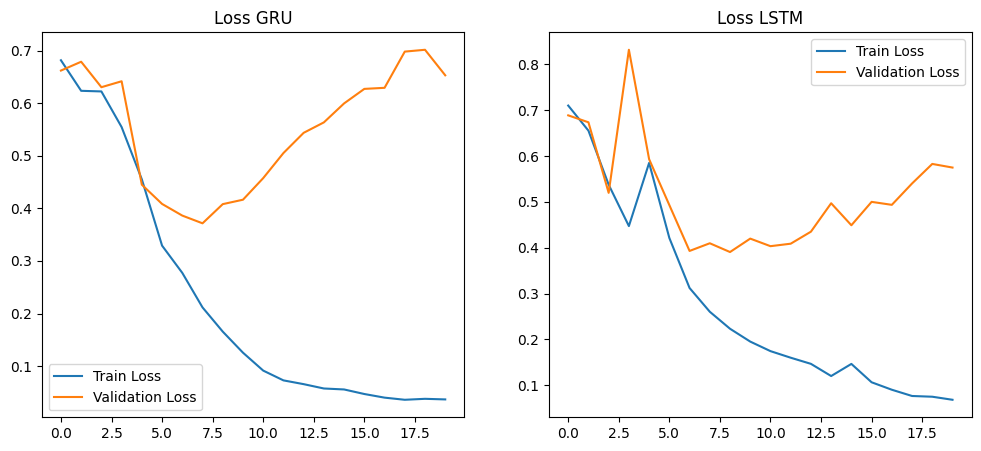

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_GRU.history['loss'], label='Train Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss GRU')

plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss LSTM')

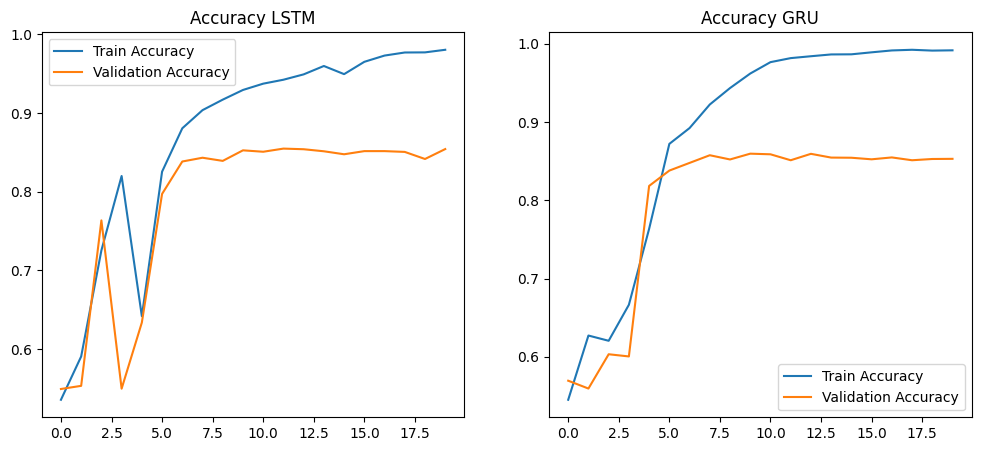

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history['accuracy'], label='Train Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy LSTM')

plt.subplot(1, 2, 2)
plt.plot(history_GRU.history['accuracy'], label='Train Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy GRU')
plt.show()

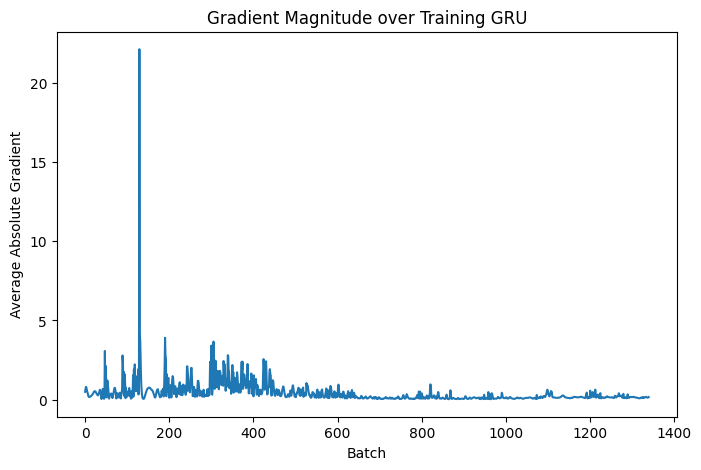

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(grad_logger_GRU.gradient_values)
plt.title("Gradient Magnitude over Training GRU")
plt.xlabel("Batch")
plt.ylabel("Average Absolute Gradient")
plt.show()

In [17]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

y_pred_lstm = (model_LSTM.predict(X_test) > 0.5).astype("int32")
y_pred_gru = (model_GRU.predict(X_test) > 0.5).astype("int32")

#metrics calculation
acc_lstm = accuracy_score(y_test, y_pred_lstm)
prec_lstm, rec_lstm, f1_lstm, _ = precision_recall_fscore_support(y_test, y_pred_lstm, average='binary')
acc_gru = accuracy_score(y_test, y_pred_gru)
prec_gru, rec_gru, f1_gru, _ = precision_recall_fscore_support(y_test, y_pred_gru, average='binary')

report_data = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "Accuracy": [acc_lstm, acc_gru],
    "Precision": [prec_lstm, prec_gru],
    "Recall": [rec_lstm, rec_gru],
    "F1 Score": [f1_lstm, f1_gru]
})

print(report_data)
print("\nLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))
print("\nGRU Classification Report:\n", classification_report(y_test, y_pred_gru))


782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
  Model  Accuracy  Precision   Recall  F1 Score
0  LSTM   0.84740   0.847483  0.84728  0.847382
1   GRU   0.84316   0.817107  0.88424  0.849349

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


GRU Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.84     12500
           1       0.82      0.88      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000

